In [1]:
# Import necessary libraries
import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure plotting
plt.style.use('seaborn-darkgrid')


In [2]:
def GoldenCrossoverSignal(file_path, short_window=20, long_window=50):
    """
    Calculate golden crossover trading signals.

    Parameters:
    file_path (str): Path to the CSV file containing stock data.
    short_window (int): The window size for the short moving average.
    long_window (int): The window size for the long moving average.

    Returns:
    pd.DataFrame: Dataframe containing trading signals.
    """
    data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    data['Prev_Close'] = data['Close'].shift(1)
    data['Short_SMA'] = data['Prev_Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_SMA'] = data['Prev_Close'].rolling(window=long_window, min_periods=1).mean()
    
    data['Signal'] = 0
    data['Signal'][short_window:] = np.where(
        data['Short_SMA'][short_window:] > data['Long_SMA'][short_window:], 1, 0
    )
    data['Position'] = data['Signal'].diff()
    
    trade_signals = data[(data['Position'] == 1) | (data['Position'] == -1)].copy()
    trade_signals['Position'] = trade_signals['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
    
    return data, trade_signals


In [3]:
def plot_trading_signals(data, trade_signals, title='Trading Signals'):
    """
    Plot trading signals on stock price data.

    Parameters:
    data (pd.DataFrame): Dataframe containing stock prices and moving averages.
    trade_signals (pd.DataFrame): Dataframe containing buy and sell signals.
    title (str): Title for the plot.
    """
    plt.figure(figsize=(14, 7))
    
    plt.plot(data['Close'], label='Stock Price', alpha=0.5)
    plt.plot(data['Short_SMA'], label='Short SMA', linestyle='--')
    plt.plot(data['Long_SMA'], label='Long SMA', linestyle='--')
    
    plt.scatter(trade_signals[trade_signals['Position'] == 'Buy'].index, 
                data['Close'][trade_signals['Position'] == 'Buy'],
                label='Buy Signal', marker='^', color='green', alpha=1)
    
    plt.scatter(trade_signals[trade_signals['Position'] == 'Sell'].index, 
                data['Close'][trade_signals['Position'] == 'Sell'],
                label='Sell Signal', marker='v', color='red', alpha=1)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [4]:
class Backtest:
    def __init__(self, initial_capital):
        self.initial_capital = initial_capital
        self.trade_log = []
        self.equity_curve = []

    def buy(self, equity_name, entry_time, entry_price, quantity):
        self.trade_log.append({
            'Equity Name': equity_name,
            'Trade': 'Buy',
            'Entry Time': entry_time,
            'Entry Price': entry_price,
            'Quantity': quantity,
            'Position Size': quantity * entry_price
        })

    def sell(self, exit_time, exit_price):
        if not self.trade_log or self.trade_log[-1]['Trade'] == 'Sell':
            return  # No position to sell

        last_trade = self.trade_log[-1]
        if last_trade['Trade'] == 'Buy':
            pnl = (exit_price - last_trade['Entry Price']) * last_trade['Quantity']
            self.trade_log.append({
                'Equity Name': last_trade['Equity Name'],
                'Trade': 'Sell',
                'Entry Time': last_trade['Entry Time'],
                'Entry Price': last_trade['Entry Price'],
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'Quantity': last_trade['Quantity'],
                'PNL': pnl,
                '% PNL': (pnl / last_trade['Position Size']) * 100
            })

    def summarize_trades(self):
        df = pd.DataFrame(self.trade_log)
        df['Cumulative PNL'] = df['PNL'].cumsum()
        return df

    def plot_equity_curve(self, trades_df):
        trades_df['Cumulative PNL'] = trades_df['Cumulative PNL'].fillna(method='ffill')
        plt.figure(figsize=(12, 6))
        plt.plot(trades_df['Exit Time'], trades_df['Cumulative PNL'], label='Equity Curve')
        plt.title('Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Cumulative PNL')
        plt.legend()
        plt.show()


    Equity Name Trade Entry Time  Entry Price  Quantity  Position Size  \
0      RELIANCE   Buy 1996-02-16    16.280588    3071.0   49997.686209   
1      RELIANCE  Sell 1996-02-16    16.280588    3071.0            NaN   
2      RELIANCE   Buy 1996-04-24    17.644445    2833.0   49986.713873   
3      RELIANCE  Sell 1996-04-24    17.644445    2833.0            NaN   
4      RELIANCE   Buy 1996-08-13    14.816763    3374.0   49991.758106   
..          ...   ...        ...          ...       ...            ...   
178    RELIANCE   Buy 2023-11-29  2408.000000      20.0   48160.000000   
179    RELIANCE  Sell 2023-11-29  2408.000000      20.0            NaN   
180    RELIANCE   Buy 2024-04-22  2944.899902      16.0   47118.398438   
181    RELIANCE  Sell 2024-04-22  2944.899902      16.0            NaN   
182    RELIANCE   Buy 2024-06-14  2940.000000      17.0   49980.000000   

     Exit Time   Exit Price           PNL      % PNL  Cumulative PNL  
0          NaT          NaN           Na

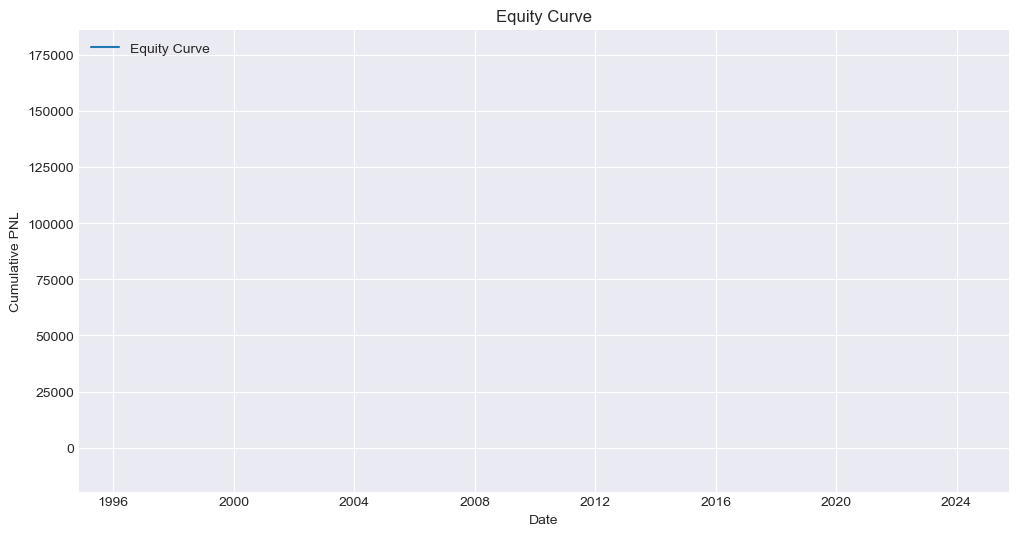

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

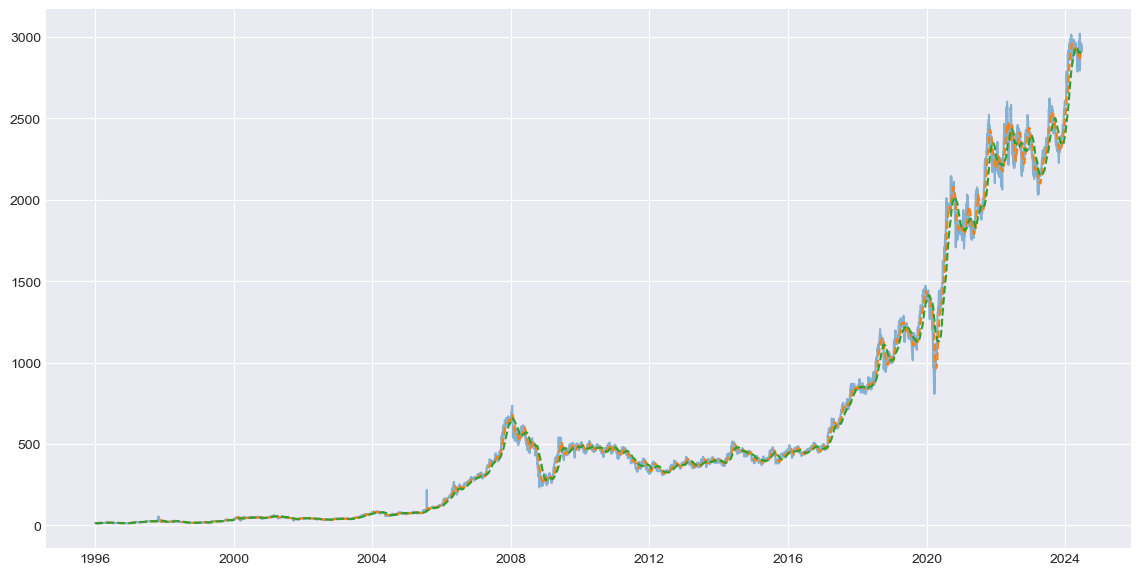

In [5]:
# Load the data and generate signals
data_path = './Datasets/RELIANCE.csv'  # Ensure the path is correct
data, trade_signals = GoldenCrossoverSignal(data_path)

# Initialize and run backtest
bt = Backtest(initial_capital=50000)
capital = bt.initial_capital

# Iterate through trade signals to execute trades
for index, row in trade_signals.iterrows():
    price = data.loc[index, 'Open']
    if row['Position'] == 'Buy':
        quantity = capital // price
        bt.buy('RELIANCE', index, price, quantity)
    elif row['Position'] == 'Sell':
        bt.sell(index, price)

# Summarize and visualize trades
trades_df = bt.summarize_trades()
print(trades_df)

# Plot the equity curve
bt.plot_equity_curve(trades_df)

# Plot trading signals
plot_trading_signals(data, trade_signals, title='Golden Crossover Trading Signals')
